# 1. Preparation:


### (a) import libraries

In [1]:
# from google.colab import files
# from google.colab import drive
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os
import pandas as pd
import seaborn as sns
import sys, requests, shutil, os

### (b) Mount notebook to Google Drive

### (c) Import dataset

In [3]:
path = "./train.csv" #directory for data
df = pd.read_csv(path)

In [4]:
df.head()

,id,url,landmark_id
0,6e158a47eb2ca3f6,https://upload.wikimedia.org/wikipedia/commons...,142820
1,202cd79556f30760,http://upload.wikimedia.org/wikipedia/commons/...,104169
2,3ad87684c99c06e1,http://upload.wikimedia.org/wikipedia/commons/...,37914
3,e7f70e9c61e66af3,https://upload.wikimedia.org/wikipedia/commons...,102140
4,4072182eddd0100e,https://upload.wikimedia.org/wikipedia/commons...,2474


In [5]:
df.shape

(4132914, 3)

In [6]:
data = df.copy()

# 2. EDA:


### (a) Sampling and data distribution

In [7]:
#Ref: https://towardsdatascience.com/google-landmark-recognition-using-transfer-learning-dde35cc760e1
#Sample only landmark_id from 1000-2000 to save time
landmark_list = [x for x in list(range(1000,2000))]
data_sample = df[df['landmark_id'].isin(landmark_list)]

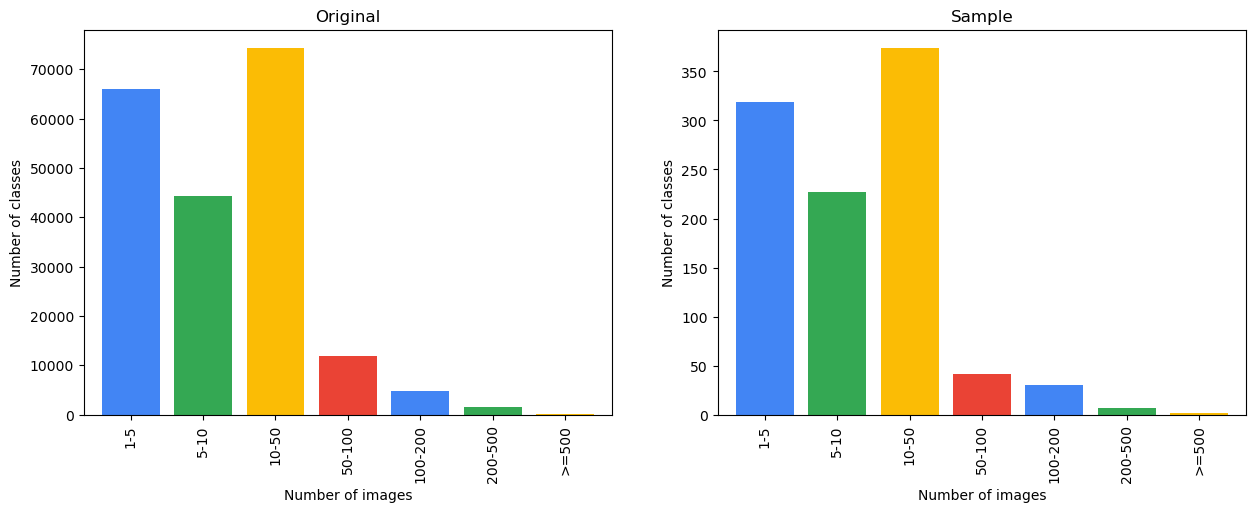

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pyplot import subplots

colors = np.array(['#4285f4','#34a853','#fbbc05','#ea4335'])
#Define the order in which to display the graph
order = ['1-5','5-10','10-50','50-100','100-200','200-500','>=500']
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))


def plot_distribution(data_f, data_k, axis):
    # data['landmark_id'].value_counts()
    x=data_f.landmark_id.value_counts().index
    y=pd.DataFrame(data_f.landmark_id.value_counts())

    #Create a variable to group the number of image sin each class
    y['Number of images'] = np.where(y['landmark_id']>=500,'>=500',y['landmark_id'])
    y['Number of images'] = np.where((y['landmark_id']>=200) & (y['landmark_id']<500),'200-500',y['Number of images'])
    y['Number of images'] = np.where((y['landmark_id']>=100) & (y['landmark_id']<200),'100-200',y['Number of images'])
    y['Number of images'] = np.where((y['landmark_id']>=50) & (y['landmark_id']<100),'50-100',y['Number of images'])
    y['Number of images'] = np.where((y['landmark_id']>=10) & (y['landmark_id']<50),'10-50',y['Number of images'])
    y['Number of images'] = np.where((y['landmark_id']>=5) & (y['landmark_id']<10),'5-10',y['Number of images'])
    y['Number of images'] = np.where((y['landmark_id']>=0) & (y['landmark_id']<5),'1-5',y['Number of images'])

    y['Number of images'].value_counts().loc[order].plot(kind = 'bar',color = colors,width = 0.8, ax=axis)
    axis.set_xlabel('Number of images')
    axis.set_ylabel('Number of classes')
    axis.set_title(data_k)
    
plot_distribution(data, 'Original', ax1)
plot_distribution(data_sample, 'Sample', ax2)

Sample shows similar distribution as fullset of data.

### (b) Display one image

In [9]:
from IPython.display import Image
from IPython.core.display import HTML 
def display_image(url):
    img_style = "width: 500px; margin: 0px; float: left; border: 1px solid black;"
    image=f"<img style='{img_style}' src='{url}' />"
    display(HTML(image))

In [10]:
display_image(df['url'][150])

### (c) Further exploring and sampling

In [11]:
#how many images does each landmark have?
df['landmark_id'].value_counts()

138982    10247
62798      4333
177870     3327
176528     3243
192931     2627
          ...  
141849        1
50554         1
18724         1
53188         1
59881         1
Name: landmark_id, Length: 203094, dtype: int64

In [12]:
#how many null values are there?
df.isnull().sum()

id             0
url            0
landmark_id    0
dtype: int64

In [13]:
#how many unqiue landmark class are there?
len(df['landmark_id'].unique())

203094

In [14]:
print("Number of classes under 100 occurences",(df['landmark_id'].value_counts() <= 100).sum(),
      'out of total number of categories',len(df['landmark_id'].unique()))

Number of classes under 100 occurences 196692 out of total number of categories 203094


In [15]:
#keeping only classes with 100 or more images, to guarantee 1% test split later.
filtered = df.groupby('landmark_id')['url'].filter(lambda x: len(x) >= 100)
df_filter = df[df['url'].isin(filtered)]

In [16]:
df_filter = df_filter.replace(to_replace='None', value=np.nan).dropna()
df_filter
#df_filter contains data without "None" as landmark_id AND only landmark_id with more than 100 urls

,id,url,landmark_id
1,202cd79556f30760,http://upload.wikimedia.org/wikipedia/commons/...,104169
4,4072182eddd0100e,https://upload.wikimedia.org/wikipedia/commons...,2474
6,6f31b874d1a4d489,https://upload.wikimedia.org/wikipedia/commons...,6888
9,8df019949b8db328,https://upload.wikimedia.org/wikipedia/commons...,81049
11,ccf070a2da242d56,https://upload.wikimedia.org/wikipedia/commons...,138982
...,...,...,...
4132900,65891c970cb09373,https://upload.wikimedia.org/wikipedia/commons...,129428
4132902,8877b1c333e1f1ad,https://upload.wikimedia.org/wikipedia/commons...,42142
4132907,e619472613f58db4,https://upload.wikimedia.org/wikipedia/commons...,83144
4132909,fc0f007893b11ba7,https://upload.wikimedia.org/wikipedia/commons...,172138


### (d) Preview mutiple images belong to same class

In [17]:
from IPython.display import Image
from IPython.core.display import HTML 

def display_category(urls):
    img_style = "width: 180px; margin: 0px; float: left; border: 1px solid black;"
    images_list = ''.join([f"<img style='{img_style}' src='{u}' />" for _, u in urls.head(12).iteritems()])
    display(HTML(images_list))

In [18]:
category = df_filter['landmark_id'].value_counts().keys()[4]
urls = df_filter[df_filter['landmark_id'] == category]['url']
display_category(urls)

### (e) Final data sample

In [19]:
#Select only id from 1000-2000 to save time
landmark_list = [x for x in list(range(1000,2000))] #changed from 1000-3000 to 2000
data_sample = df_filter[df_filter['landmark_id'].isin(landmark_list)]

In [20]:
#Save final sample as csv file to avoid re-running the above code everytime.
# data_sample.to_csv('clean_data.csv', index=False)
# files.download('clean_data.csv')
#Need to write read.csv function if needed

# 3. Downloading Images

### (a) Change URLs to resize images to target size

### (b) Train-Test split

In [23]:
data_test = pd.DataFrame(columns = ['id','url','landmark_id'])
data_training_all = pd.DataFrame(columns = ['id','url','landmark_id'])
percent_test = 0.01 #takes 1% from each class as holdout data

import random
random.seed(42)
for landmark_id in set(data_sample['landmark_id']):
    n=1
    t = data_sample[(data_sample.landmark_id == landmark_id)] #get all images for a landmark id
    i = 0
    r =[]
    while i < len(t.id):
        it = i
        r.append(t.id.iloc[it])  #create a list of all these images
        i += 1
        
    test = random.sample(r,int(percent_test*len(r))) #randomly pick a sample of 1% images from list 'r'
    training = list(set(r) - set(test))  #get the remaining images
    data_t = data_sample[data_sample.id.isin(test)] #holdout dataset
    data_tr = data_sample[data_sample.id.isin(training)] #training dataset
    data_test = pd.concat([data_test,data_t])  
    data_training_all = pd.concat([data_training_all,data_tr])
    n+=1

print ('2. train and test set created')

2. train and test set created


### (c) Train_Validation split

In [24]:
data_valid = pd.DataFrame(columns = ['id','url','landmark_id'])
data_train = pd.DataFrame(columns = ['id','url','landmark_id'])
percent_validation = 0.2 #takes 20% from each class as holdout data
import random
random.seed(42)
for landmark_id in set(data_training_all['landmark_id']):
    n=1
    t = data_training_all[(data_training_all.landmark_id == landmark_id)]
    i = 0
    r =[]
    while i < len(t.id):
        it = i
        r.append(t.id.iloc[it])
        i += 1
        
    valid = random.sample(r,int(percent_validation*len(r)))
    train = list(set(r) - set(valid)) 
    data_v = data_training_all[data_training_all.id.isin(valid)]
    data_t = data_training_all[data_training_all.id.isin(train)]
    data_valid = pd.concat([data_valid,data_v])
    data_train = pd.concat([data_train,data_t])
    n+=1

print ('3. train and validation set created')

3. train and validation set created


### (d) Check sizes after split

In [25]:
print (len(data_train))
#print (data_train['landmark_id'].values.max())
print (len(data_valid))
print (len(data_test))

6227
1538
65


### (e) Downloading Images to existing folders in drive

Create directories 'N_train_images_model', 'M_validation_images_model', 'N_test_images_from_train' inside 'Data' folder before running the code below.



In [27]:
#function to fetch images
def fetch_image(path,folder):
    url=path
    response=requests.get(url, stream=True)
    path = './Data/'+ folder + '/image.jpg'
    with open(path, 'wb') as out_file:
        shutil.copyfileobj(response.raw, out_file)
    del response


In [65]:
import urllib.request
from PIL import Image
  
# Retrieving the resource located at the URL
# and storing it in the file name a.png  
k = 0
def fetch_image(url,folder):
    # Opening the image and displaying it (to confirm its presence)
    try:
        urllib.request.urlretrieve(url, folder)
        img = Image.open(folder)
        
        #resize
        img = img.resize((96,96))
        img.save(folder, 'JPEG', quality=90)
    except:
        #remove files that cannot be opened
        if os.path.exists(folder):
            os.remove(folder)
            k += 1
        print(url)
        print('error')
    

In [ ]:
'''TRAIN SET - fetch images for the resized URLs and save in the already created directory train_images_model'''
dir = './Data/N_train_images_model/'
i=0
for link in data_train['url']: 
    if os.path.exists(dir + str(data_train['id'].iloc[i])+ '.jpg'):
        # print('hi')
        i += 1
        continue
    folder = str(data_train['id'].iloc[i])+ '.jpg'
    fetch_image(link, dir + folder)
    i+=1
    # if(i==1):   #uncomment to test in machine speed
    #     break 
print(i)

print('4. train images fetched')

In [34]:
import cv2
img = cv2.imread('./Data/N_train_images_model/6a27e8b1ac9f6ae5.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
print('Original Dimensions : ',img.shape)

Original Dimensions :  (96, 96, 3)


In [ ]:
'''VALIDATION SET'''
dir = './Data/M_validation_images_model/'
i=0
for link in data_valid['url']: 
    if os.path.exists(dir + str(data_valid['id'].iloc[i])+ '.jpg'):
        print('hi')
        i += 1
        continue
    folder = str(data_valid['id'].iloc[i])+ '.jpg'
    fetch_image(link, dir + folder)
    i+=1
    # if(i==1):   #uncomment to test in machine speed
    #     break 
print(i)
print('5. Validation images fetched')

In [ ]:
'''TEST SET''' #N_test_images_from_train
dir = './Data/N_test_images_from_train/'
i=0
for link in data_test['url']: 
    if os.path.exists(dir + str(data_test['id'].iloc[i])+ '.jpg'):
        print('hi')
        i += 1
        continue
    folder = str(data_test['id'].iloc[i]) + '.jpg'
    fetch_image(link, dir + folder)
    i+=1
    # if(i==1):   #uncomment to test in machine speed
    #     break
    
print(i)
print('6. Test images fetched') 